# Colorectal histology dataset with LeNet 5

# Preview: Neural Network examples with `tf.keras`

- `tf.keras` Software (http://keras.io/);

- Visual example of LeNet-5 (http://yann.lecun.com/exdb/lenet/) using MNIST digits dataset;

- Examples with common neural network topologies (https://machinelearningmastery.com/tensorflow-tutorial-deep-learning-with-tf-keras/).

## Colorectal histology

Methods to diagnose colorectal using histology images (<https://zenodo.org/record/53169#.XGZemKwzbmG>, <https://www.tensorflow.org/datasets/catalog/colorectal_histology>)

In this case, the purpose is to classify the type of histology in a given image in the following categories:

- 0: TUMOR
- 1: STROMA
- 2: COMPLEX
- 3: LYMPHO
- 4: DEBRIS
- 5: MUCOSA
- 6: ADIPOSE
- 7: EMPTY

## Local instalation (option 1)

Install the following Python packages to run this notebook

`pip install pip -U`

`pip install tensorflow jupyter`

## Google Colab (option 2)

[Google Colab](https://colab.research.google.com/) is a research project created to help disseminate machine learning education and research. It's a `Jupyter notebook` environment that requires no setup to use and runs entirely in the cloud.

Colaboratory notebooks are stored in [Google Drive](https://drive.google.com) and can be shared just as you would with Google Docs or Sheets. Colaboratory is free to use.

For more information, see our [FAQ](https://research.google.com/colaboratory/faq.html).

### How install extra packages
Google Colab installs a series of basic packages if we need any additional package just install it.

In [3]:
!pip install -q keras sklearn
!pip install shap

     |████████████████████████████████| 327kB 20.5MB/s 
  Created wheel for shap: filename=shap-0.37.0-cp36-cp36m-linux_x86_64.whl size=463906 sha256=6aa50a7ec2ad72aba5abb3e92a9ea0eb2fdce3945e1015e055aeac90a05e6006
  Stored in directory: /root/.cache/pip/wheels/df/ad/b0/aa7815ec68850d66551ef618095eccb962c8f6022f1d3dd989
Successfully built shap


## Import packages

In [22]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import collections

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics

import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow import keras
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img, ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

import pkg_resources
pkg_resources.require("Scipy==1.4.1")

import scipy
from scipy.stats import wilcoxon
import warnings
warnings.filterwarnings('ignore')

import shap
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input, decode_predictions
import keras.backend as K
import json

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation, Input, Flatten, MaxPooling2D
from keras.layers.convolutional import Conv2D


## Define global constants

Lets start with a few epochs to test learning network parameters

In [23]:
#Function to set the number of epochs and batches
def set_epochs_batches(epochs_number , batches ): 
  epochs= epochs_number
  batch_size = batches
  return 

In [24]:
batch_size = 32 #Number of training examples
nb_classes = 8 #or 8
epochs = 5 #Number of iterations // Passes the entire training has completed
# Scaling input image to theses dimensions
img_rows, img_cols = 32, 32

## Load image database

In [25]:
def format_example(image):
    image = tf.cast(image, tf.float32)
    # Normalize the pixel values
    image = image / 255.0
    # Resize the image
    image = tf.image.resize(image, (img_rows, img_cols))
    return image


def load_data(name="colorectal_histology"):
  train_ds = tfds.load(name, split=tfds.Split.TRAIN, batch_size=-1)
  train_ds['image'] = tf.map_fn(format_example, train_ds['image'], dtype=tf.float32)
  numpy_ds = tfds.as_numpy(train_ds)
  X, y = numpy_ds['image'], numpy_ds['label']

  return np.array(X), np.array(y)

## Plot images

In [26]:
def plot_symbols(X,y,n=15):
    index = np.random.randint(len(y), size=n)
    plt.figure(figsize=(25, 2))
    for i in np.arange(n):
        ax = plt.subplot(1,n,i+1)
        plt.imshow(X[index[i],:,:,:])
        plt.gray()
        ax.set_title(f'{y[index[i]]}-{index[i]}')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

## Build LeNet5 structure

<center><img src="https://www.dlsi.ua.es/~juanra/UA/curso_verano_DL/images/LeNet5.jpg"></center>

In [27]:
model_preset = 0

In [28]:
#
# Build an ANN structure - LeNet5
#
# The model will receive the activation functions
def cnn_model(activation_functions):
    #
    # Neural Network Structure
    #
    
    #model = Sequential()
    
    
    #model.add(layers.Conv2D(6, (5, 5))) #Output dimensionality, kernel_size (Height, width)
    #model.add(layers.Activation(activation_functions[0])) #Applies an activation function to an output
    #model.add(layers.MaxPooling2D(pool_size=(2, 2))) #Getting a size 2x2 for the window
    
    #model.add(layers.Conv2D(16, (5, 5)))
    #model.add(layers.Activation(activation_functions[1]))
    #model.add(layers.MaxPooling2D(pool_size=(2, 2)))
        
    #model.add(layers.Flatten())
    
    #model.add(layers.Dense(120)) #dense(Dimensionality of the output space)
    #model.add(layers.Activation(activation_functions[2]))
    
    #model.add(layers.Dense(84))
    #model.add(layers.Activation(activation_functions[3]))
    
    #model.add(layers.Dense(nb_classes))
    #model.add(layers.Activation(activation_functions[4]))
    if model_preset == 0: 
      v = Input(shape=(X.shape[1:]),name='img')
      
      #FIRST BRANCH
      conv = Conv2D(6,(5,5))(v)
      activation_layer_1 = Activation(activation_functions[0])(conv)
      max_pooling_2d_1 = MaxPooling2D(pool_size=(2,2))(activation_layer_1)
      
      #SECOND BRANCH
      conv2 = Conv2D(16,(5,5))(max_pooling_2d_1)
      activation_layer_2 = Activation(activation_functions[1]) (conv2)
      max_pooling_2d_2 = MaxPooling2D(pool_size=(2,2)) (activation_layer_2)

      flatten = Flatten()(max_pooling_2d_2)
      
      #THIRD BRANCH
      layer_dense_1 = Dense(120)(flatten)
      activation_layer_3 = Activation(activation_functions[2]) (layer_dense_1 )
      
      #Fourth BRANCH 
      layer_dense_2 = Dense(84)(activation_layer_3)
      activation_layer_4 = Activation(activation_functions[3]) (layer_dense_2)
      
      layer_dense_3 = Dense(nb_classes)(activation_layer_4)
      activation_layer_5 = Activation(activation_functions[4]) (layer_dense_3)
    else:
      v = Input(shape=(X.shape[1:]),name='img')
    
      #FIRST BRANCH
      conv = Conv2D(6,(5,5), padding='same')(v)
      activation_layer_1 = Activation(activation_functions[0])(conv)
      max_pooling_2d_1 = MaxPooling2D(pool_size=(2,2))(activation_layer_1)
      
      #SECOND BRANCH
      conv2 = Conv2D(16,(5,5), padding='valid')(max_pooling_2d_1)
      activation_layer_2 = Activation(activation_functions[1]) (conv2)
      max_pooling_2d_2 = MaxPooling2D(pool_size=(2,2)) (activation_layer_2)

      flatten = Flatten()(max_pooling_2d_2)
      
      #THIRD BRANCH
      layer_dense_1 = Dense(120)(flatten)
      activation_layer_3 = Activation(activation_functions[2]) (layer_dense_1 )
      
      #Fourth BRANCH 
      layer_dense_2 = Dense(84)(activation_layer_3)
      activation_layer_4 = Activation(activation_functions[3]) (layer_dense_2)
      
      layer_dense_3 = Dense(nb_classes)(activation_layer_4)
      activation_layer_5 = Activation(activation_functions[4]) (layer_dense_3)


    

    return Model(inputs=v , outputs=activation_layer_5)

## Start to run the program

### Load data

In [29]:
##################################################################################
# Main program

X, y = load_data()
print("Los resultados que hemos obtenido, son los siguientes")

print(X.shape, 'train samples')
print(img_rows,'x', img_cols, 'image size')
print(epochs,'epochs')

Los resultados que hemos obtenido, son los siguientes
(5000, 32, 32, 3) train samples
32 x 32 image size
5 epochs


## Adjusting Gamma

In [30]:
def adjust_image(gamma): 
  from skimage import exposure
  for x_i in range(len(X)):
    X[x_i] = exposure.adjust_log(X[x_i],1) 
    X[x_i] = exposure.adjust_sigmoid(X[x_i],0.9) 
    X[x_i]= exposure.adjust_gamma(X[x_i],gamma)
    
  return

In [ ]:
adjust_image(1/2.8)

Only for binary classification. All number of classes greater than 0 will be set to 1.

In [31]:
if nb_classes==2:
  y[y>0] = 1

### Let to see examples of the dataset

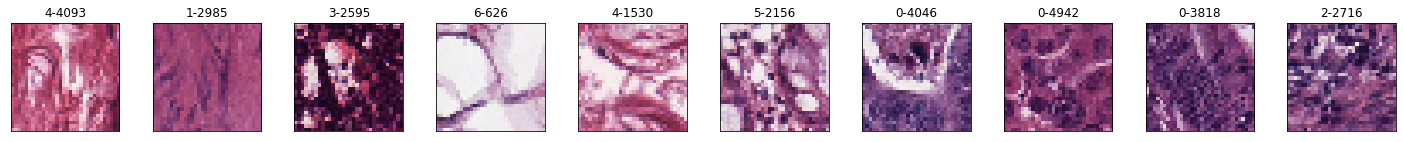

In [32]:
plot_symbols(X, y, 10)

## Number of examples per class

In [33]:
collections.Counter(y)

Counter({0: 625, 1: 625, 2: 625, 3: 625, 4: 625, 5: 625, 6: 625, 7: 625})

#Fucntion to create some models with different epochs in order to compare each other and get the best one

In [34]:
def gest_best_image_adjust():
  picture_gammas = [1/2.8, 1/2.2, 1,1.5 ]
  best_gamma = 0
  best_acc = 0
  best_auc=0
  with_data_augmentation = True
  best_function = ["relu", "relu", "relu", "relu", "softmax"]
  last_acc_percent_per_fold= []
  last_auc_percent_per_fold=[]
  for gamma in picture_gammas:
    X, y = load_data()
    if gamma != 1: adjust_image(gamma)
    acc_per_fold, loss_per_fold, auc_per_fold, acc_percent_per_fold, auc_percent_per_fold, model = cross_validation(10 , best_function , 'adam' , True , 32 , 8)
    plt.plot(range(len( acc_percent_per_fold)) , acc_percent_per_fold , label=best_function[0] + ", " +  best_function[4] + " [ " + str(8) + ", " + str(32) + ", " + str(gamma) + ", " + str(True)  +" ]")
    total_acc = 0
    total_auc = 0
    for i in range(len(acc_per_fold)): 
      total_acc = total_acc + acc_per_fold[i]
      total_auc = total_auc + auc_per_fold[i]
    media_value_acc = total_acc/len(acc_per_fold)
    media_value_auc = total_auc/len(auc_per_fold)
    print("The media value acc is  " , media_value_acc , "And the value auc is " , media_value_auc , "And the gamma is " , gamma)
    if media_value_acc > best_acc-0.05 and media_value_auc > best_auc-0.05: 
      if len(last_acc_percent_per_fold)>0: 
        wilcox_v_acc, p_val_acc = wilcoxon(acc_percent_per_fold , last_acc_percent_per_fold)  
        wilcox_v_auc, p_val_auc = wilcoxon(auc_percent_per_fold, last_auc_percent_per_fold)
        if p_val_acc<0.05 and p_val_auc < 0.05: #Rechazamos la hipótesis nula
          best_gamma = gamma
          last_acc_percent_per_fold = acc_percent_per_fold
          last_auc_percent_per_fold = auc_percent_per_fold
          best_acc = media_value_acc
          best_auc = media_value_auc
      else: 
        best_gamma = gamma
        last_acc_percent_per_fold = acc_percent_per_fold
        last_auc_percent_per_fold = auc_percent_per_fold
        best_acc = media_value_acc
        best_auc = media_value_auc
  print("AND WITH THE GAMMA " , best_gamma)
  print("THE BEST MODEL IS " , best_function )
  print("BEST MEDIA AUC " ,best_auc)
  print("BEST MEDIA ACC " , best_acc)
  print("AND WITH DATA_AUGMENTATION "  , with_data_augmentation )
  print("FIRST MODEL GRAPHIC")
  plt.ylabel('Aciertos')
  plt.xlabel('Fold')
  plt.legend()
  return

In [35]:
def get_best_minor_scale(): 
  picture_sizings = [32, 26, 22,14 ]
  best_sizing = 0
  best_acc = 0
  best_auc=0
  with_data_augmentation = True
  best_function = ["relu", "relu", "relu", "relu", "softmax"]
  last_acc_percent_per_fold= []
  last_auc_percent_per_fold=[]
  for sizing in picture_sizings:
    img_rows= sizing
    img_cols = sizing
    X, y = load_data()
    acc_per_fold, loss_per_fold, auc_per_fold, acc_percent_per_fold, auc_percent_per_fold, model = cross_validation(10 , best_function , 'adam' , True , 32 , 8)
    plt.plot(range(len( auc_percent_per_fold)) , auc_percent_per_fold , label=best_function[0] + ", " +  best_function[4] + " [ " + str(8) + ", " + str(32) + ", " + str(sizing) + ", " + str(True)  +" ]")
    #Getting the media_value
    total_acc = 0
    total_auc = 0
    for i in range(len(acc_per_fold)): 
      total_acc = total_acc + acc_per_fold[i]
      total_auc = total_auc + auc_per_fold[i]

    media_value_acc = total_acc/len(acc_per_fold)
    media_value_auc = total_auc/len(auc_per_fold)
    print("The media value acc is  " , media_value_acc , "And the value auc is " , media_value_auc , "And the scale is " , sizing)
    if media_value_acc > best_acc-0.05 and media_value_auc > best_auc-0.05: 
      if len(last_acc_percent_per_fold)>0: 
        wilcox_v_acc, p_val_acc = wilcoxon(acc_percent_per_fold , last_acc_percent_per_fold)  
        wilcox_v_auc, p_val_auc = wilcoxon(auc_percent_per_fold, last_auc_percent_per_fold)
        if p_val_acc<0.05 and p_val_auc < 0.05: #Rechazamos la hipótesis nula
          best_sizing = sizing
          last_acc_percent_per_fold = acc_percent_per_fold
          last_auc_percent_per_fold = auc_percent_per_fold
          best_acc = media_value_acc
          best_auc = media_value_auc
          
      else: 
        best_sizing = sizing
        last_acc_percent_per_fold = acc_percent_per_fold
        last_auc_percent_per_fold = auc_percent_per_fold
        best_acc = media_value_acc
        best_auc = media_value_auc
  
 
  print("AND WITH THE SIZING " + best_sizing)
  print("THE BEST MODEL IS " , best_function )
  print("BEST MEDIA AUC " ,best_auc)
  print("BEST MEDIA ACC " , best_acc)
  print("FIRST MODEL GRAPHIC")
  plt.ylabel('Aciertos')
  plt.xlabel('Fold')
  plt.legend()
  return

In [36]:
get_best_minor_scale()

KeyboardInterrupt: ignored

In [ ]:
def get_best_optimizer(data_augmentation): 
  optimizers = ['adam' , 'sgd' , 'adadelta'] 
  best_acc = 0
  best_auc=0
  best_optimizer = ''
  with_data_augmentation = True
  best_function = ["relu", "relu", "relu", "relu", "softmax"]
  best_epoch_number = 0
  best_batch_number = 0
  set_epochs_batches(8,32 ) #Probamos cuál es el mejor modelo con las mismas épocas y batches
  best_epoch = 8
  best_batch_number= 32
  last_acc_percent_per_fold= []
  last_auc_percent_per_fold=[]
  for optimizer_i in optimizers:
    epochs = 8
    batch_size = 32
    #set_epochs_batches(epoch_i , batch_i ) 
    print("The new size is " , str(epochs) , ", " , batch_size)
    #Getting the result
    acc_per_fold, loss_per_fold, auc_per_fold, acc_percent_per_fold, auc_percent_per_fold, model = cross_validation(10 , best_function , optimizer_i , True , 32 , 8)
    plt.plot(range(len( auc_percent_per_fold)) , auc_percent_per_fold , label=best_function[0] + ", " +  best_function[4] + " [ " + str(8) + ", " + str(32) + ", " + str(optimizer_i) + ", " + str(True)  +" ]")
    #Getting the media_value
    total_acc = 0
    total_auc = 0
    for i in range(len(acc_per_fold)): 
      total_acc = total_acc + acc_per_fold[i]
      total_auc = total_auc + auc_per_fold[i]

    media_value_acc = total_acc/len(acc_per_fold)
    media_value_auc = total_auc/len(auc_per_fold)
    print("The media value acc is  " , media_value_acc , "And the value auc is " , media_value_auc , "And the activation optimizer is " , optimizer_i)
    if media_value_acc > best_acc and media_value_auc > best_auc: 
      if len(last_acc_percent_per_fold)>0: 
        wilcox_v_acc, p_val_acc = wilcoxon(acc_percent_per_fold , last_acc_percent_per_fold)  
        wilcox_v_auc, p_val_auc = wilcoxon(auc_percent_per_fold, last_auc_percent_per_fold)
        if p_val_acc<0.05 and p_val_auc < 0.05: #Rechazamos la hipótesis nula
          last_acc_percent_per_fold = acc_percent_per_fold
          last_auc_percent_per_fold = auc_percent_per_fold
          best_acc = media_value_acc
          best_auc = media_value_auc
          best_epoch_number = 8
          best_batch_number = 32
          best_optimizer =optimizer_i
      else: 
        last_acc_percent_per_fold = acc_percent_per_fold
        last_auc_percent_per_fold = auc_percent_per_fold
        best_acc = media_value_acc
        best_auc = media_value_auc
        best_epoch_number = 8
        best_batch_number = 32
        best_optimizer =optimizer_i

    
  print("AND WITH THE OPTIMIZER " + best_optimizer)
  print("THE BEST MODEL IS " , best_function )
  print("WITH A EPOCH_NUMBER OF " , best_epoch_number , " AND A BATCH SIZE OF " , best_batch_number )
  print("BEST MEDIA AUC " ,best_auc)
  print("BEST MEDIA ACC " , best_acc)
  print("AND WITH DATA_AUGMENTATION "  , with_data_augmentation )
  print("FIRST MODEL GRAPHIC")
  plt.ylabel('Aciertos')
  plt.xlabel('Fold')
  plt.legend()
  return

In [ ]:
def get_best_epoch(data_augmentation , optimizer_i ):
  best_acc = 0
  best_auc=0
  best_optimizer = ''
  with_data_augmentation = True
  best_function = ["relu", "relu", "relu", "relu", "softmax"]
  best_epoch_number = 0
  best_batch_number = 0
  set_epochs_batches(8,32 ) #Probamos cuál es el mejor modelo con las mismas épocas y batches
  best_epoch = 8
  best_batch_number= 32
  last_acc_percent_per_fold= []
  last_auc_percent_per_fold=[]
  for epoch_i  in range(5,15): 
    epochs = epoch_i
    batch_size = 34
    #set_epochs_batches(epoch_i , batch_i ) 
    print("The new size is " , str(epochs) , ", " , batch_size)
    #Getting the result
    acc_per_fold, loss_per_fold, auc_per_fold, acc_percent_per_fold, auc_percent_per_fold, model = cross_validation(10 , best_function , 'adam' , True , 32 , epoch_i)
    plt.plot(range(len( auc_percent_per_fold)) , auc_percent_per_fold , label=best_function[0] + ", " +  best_function[4] + " [ " + str(epoch_i) + ", " + str(32) + ", " + str(optimizer_i) + ", " + str(True)  +" ]")
     #Getting the media_value
    total_acc = 0
    total_auc = 0
    for i in range(len(acc_per_fold)): 
      total_acc = total_acc + acc_per_fold[i]
      total_auc = total_auc + auc_per_fold[i]

    media_value_acc = total_acc/len(acc_per_fold)
    media_value_auc = total_auc/len(auc_per_fold)
    print("The media value acc is  " , media_value_acc , "And the value auc is " , media_value_auc , "And the activation epoch is " , epoch_i)
    if media_value_acc > best_acc and media_value_auc > best_auc: 
      if len(last_acc_percent_per_fold)>0: 
        wilcox_v_acc, p_val_acc = wilcoxon(acc_percent_per_fold , last_acc_percent_per_fold)  
        wilcox_v_auc, p_val_auc = wilcoxon(auc_percent_per_fold, last_auc_percent_per_fold)
        if p_val_acc<0.05 and p_val_auc < 0.05: #Rechazamos la hipótesis nula
          last_acc_percent_per_fold = acc_percent_per_fold
          last_auc_percent_per_fold = auc_percent_per_fold
          best_acc = media_value_acc
          best_auc = media_value_auc
          best_epoch_number = epoch_i
          best_batch_number = 32
          best_optimizer ='adam'
      else: 
        last_acc_percent_per_fold = acc_percent_per_fold
        last_auc_percent_per_fold = auc_percent_per_fold
        best_acc = media_value_acc
        best_auc = media_value_auc
        best_epoch_number = epoch_i
        best_batch_number = 32
        best_optimizer =optimizer_i

    
  print("AND WITH THE OPTIMIZER " + best_optimizer)
  print("THE BEST MODEL IS " , best_function )
  print("WITH A EPOCH_NUMBER OF " , best_epoch_number , " AND A BATCH SIZE OF " , best_batch_number )
  print("BEST MEDIA AUC " ,best_auc)
  print("BEST MEDIA ACC " , best_acc)
  print("AND WITH DATA_AUGMENTATION "  , with_data_augmentation )
  print("FIRST MODEL GRAPHIC")
  plt.ylabel('Aciertos')
  plt.xlabel('Fold')
  plt.legend()
  return

In [ ]:

def get_best_activation_function(data_augmentation):
  activation_functions = []
  activation_functions.append(["sigmoid", "sigmoid" , "sigmoid", "sigmoid" , "softmax"])
  activation_functions.append( ["relu", "relu", "relu", "relu", "softmax"])
  activation_functions.append(["tanh", "tanh", "tanh", "tanh", "softmax"] )
  
  
  best_acc = 0
  best_auc=0
  best_optimizer = ''
  with_data_augmentation = True
  best_function = ["tanh", "tanh", "tanh", "tanh", "softmax"]
  best_epoch_number = 0
  best_batch_number = 0
  set_epochs_batches(8,32 ) #Probamos cuál es el mejor modelo con las mismas épocas y batches
  best_epoch = 8
  best_batch_number= 32
  last_acc_percent_per_fold= []
  last_auc_percent_per_fold=[]
 
  #Pondremos el optimizador de adam
  for activation_function in activation_functions: 
    acc_per_fold, loss_per_fold, auc_per_fold, acc_percent_per_fold, auc_percent_per_fold, model = cross_validation(10 , activation_function , "adam" , data_augmentation , 32,8)
    print("Sacando la gráfica del modelo")
    plt.plot(range(len( auc_percent_per_fold)) , auc_percent_per_fold , label=str(activation_function[0]) + ", " +  activation_function[4] )
    #Getting the media_value
    total_acc = 0
    total_auc = 0
    for i in range(len(acc_per_fold)): 
      total_acc = total_acc + acc_per_fold[i]
      total_auc = total_auc + auc_per_fold[i]

    media_value_acc = total_acc/len(acc_per_fold)
    
    media_value_auc = total_auc/len(auc_per_fold)
    print("The media value acc is  " , media_value_acc , "And the value auc is " , media_value_auc , "And the activation function is " , activation_function)
    if media_value_acc > best_acc and media_value_auc > best_auc: 
      if len(last_acc_percent_per_fold)>0: 
        wilcox_v_acc, p_val_acc = wilcoxon(acc_percent_per_fold , last_acc_percent_per_fold)  
        wilcox_v_auc, p_val_auc = wilcoxon(auc_percent_per_fold, last_auc_percent_per_fold)
        if p_val_acc<0.05 and p_val_auc < 0.05: #Rechazamos la hipótesis nula
          last_acc_percent_per_fold = acc_percent_per_fold
          last_auc_percent_per_fold = auc_percent_per_fold
          best_function = activation_function
          best_acc = media_value_acc
          best_auc = media_value_auc
          best_epoch_number = 8
          best_batch_number = 32
          best_optimizer ='adam'
      else: 
        last_acc_percent_per_fold = acc_percent_per_fold
        last_auc_percent_per_fold = auc_percent_per_fold
        best_function = activation_function
        best_acc = media_value_acc
        best_auc = media_value_auc
        best_epoch_number = 8
        best_batch_number = 32
        best_optimizer ='adam'

    
  print("AND WITH THE OPTIMIZER " + best_optimizer)
  print("THE BEST MODEL IS " , best_function )
  print("WITH A EPOCH_NUMBER OF " , best_epoch_number , " AND A BATCH SIZE OF " , best_batch_number )
  print("BEST MEDIA AUC " ,best_auc)
  print("BEST MEDIA ACC " , best_acc)
  print("AND WITH DATA_AUGMENTATION "  , with_data_augmentation )
  print("FIRST MODEL GRAPHIC")
  plt.ylabel('Aciertos')
  plt.xlabel('Fold')
  plt.legend()
  return

Before  4500
Y TRAIN [7 7 6 ... 5 4 4]
After  562
X_train (4500, 32, 32, 3) X_test (500, 32, 32, 3)
y_train (4500,) y_test (500,)
y_train_nn (4500, 8) y_test_nn (500, 8)
The batch and the epoch are   32 ,  8
127/127 - 1s - loss: 2.0336 - accuracy: 0.1728 - val_loss: 1.6947 - val_accuracy: 0.2289
Predictions Counter({2: 342, 6: 145, 1: 6, 4: 6, 5: 1}) 

Confusion matrix
[[ 0  1 62  0  0  0  0  0]
 [ 0  1 59  0  0  1  2  0]
 [ 0  1 61  0  0  0  0  0]
 [ 0  0 62  0  0  0  0  0]
 [ 0  2 42  0  5  0 14  0]
 [ 0  1 56  0  1  0  4  0]
 [ 0  0  0  0  0  0 62  0]
 [ 0  0  0  0  0  0 63  0]] 

              precision    recall  f1-score   support

       TUMOR       0.00      0.00      0.00        63
      STROMA       0.17      0.02      0.03        63
     COMPLEX       0.18      0.98      0.30        62
      LYMPHO       0.00      0.00      0.00        62
      DEBRIS       0.83      0.08      0.14        63
      MUCOSA       0.00      0.00      0.00        62
     ADIPOSE       0.43      1

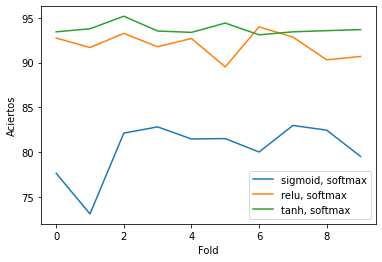

In [ ]:
get_best_activation_function(False)

Before  4500
Y TRAIN [7 7 6 ... 5 4 4]
After  562
X_train (4500, 32, 32, 3) X_test (500, 32, 32, 3)
y_train (4500,) y_test (500,)
y_train_nn (4500, 8) y_test_nn (500, 8)
The batch and the epoch are   32 ,  8
Epoch 1/8
141/140 [==============================] - 2s 15ms/step - loss: 1.9652 - accuracy: 0.1858
Epoch 2/8
141/140 [==============================] - 2s 15ms/step - loss: 1.4495 - accuracy: 0.3631
Epoch 3/8
141/140 [==============================] - 2s 15ms/step - loss: 1.2473 - accuracy: 0.4329
Epoch 4/8
141/140 [==============================] - 2s 15ms/step - loss: 1.1539 - accuracy: 0.4891
Epoch 5/8
141/140 [==============================] - 2s 15ms/step - loss: 1.0958 - accuracy: 0.5173
Epoch 6/8
141/140 [==============================] - 2s 15ms/step - loss: 1.0998 - accuracy: 0.5091
Epoch 7/8
141/140 [==============================] - 2s 15ms/step - loss: 1.0726 - accuracy: 0.5196
Epoch 8/8
141/140 [==============================] - 2s 15ms/step - loss: 1.0647 - accuracy:

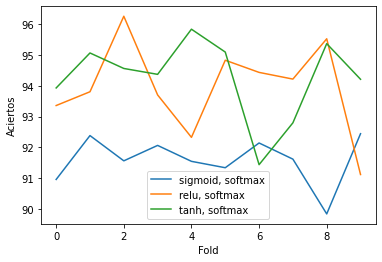

In [ ]:
get_best_activation_function(True)

The new size is  8 ,  32
Before  4500
Y TRAIN [7 7 6 ... 5 4 4]
After  562
X_train (4500, 32, 32, 3) X_test (500, 32, 32, 3)
y_train (4500,) y_test (500,)
y_train_nn (4500, 8) y_test_nn (500, 8)
The batch and the epoch are   32 ,  8
Epoch 1/8
141/140 [==============================] - 2s 15ms/step - loss: 1.3764 - accuracy: 0.3962
Epoch 2/8
141/140 [==============================] - 2s 15ms/step - loss: 1.0568 - accuracy: 0.5478
Epoch 3/8
141/140 [==============================] - 2s 15ms/step - loss: 1.0071 - accuracy: 0.5787
Epoch 4/8
141/140 [==============================] - 2s 15ms/step - loss: 0.9307 - accuracy: 0.6184
Epoch 5/8
141/140 [==============================] - 2s 15ms/step - loss: 0.9365 - accuracy: 0.6082
Epoch 6/8
141/140 [==============================] - 2s 15ms/step - loss: 0.9189 - accuracy: 0.6104
Epoch 7/8
141/140 [==============================] - 2s 15ms/step - loss: 0.8693 - accuracy: 0.6464
Epoch 8/8
141/140 [==============================] - 2s 15ms/step -

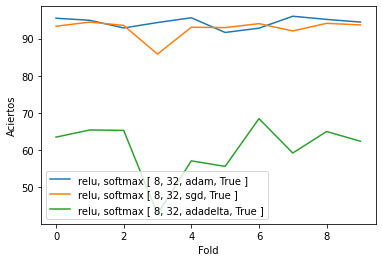

In [ ]:
get_best_optimizer(True)

This section is introductory to serve as a simple example. To test the model created in different situations, a 10 cross validation (10-CV) strategy should be used. 

In [ ]:
get_best_epoch(True, 'adam')

The new size is  5 ,  34
Before  4500
Y TRAIN [7 7 6 ... 5 4 4]
After  562
X_train (4500, 32, 32, 3) X_test (500, 32, 32, 3)
y_train (4500,) y_test (500,)
y_train_nn (4500, 8) y_test_nn (500, 8)
The batch and the epoch are   32 ,  5
Epoch 1/5
132/140 [===========================>..] - ETA: 0s - loss: 1.3868 - accuracy: 0.3879

KeyboardInterrupt: ignored

#KFOLD VALIDATION,BALANCING AND OVERSIZING DATASETS




In [37]:
datagen = ImageDataGenerator(
  rotation_range=5,
  width_shift_range=0.1,
  height_shift_range=0.1,
  horizontal_flip=False)

In [38]:
def get_score(X_train, X_test, y_test, y_train_nn, y_test_nn, activation_function, optimizer , data_augmentation, batch_size , epochs, auc_per_fold, auc_percent_per_fold ):
  print("The batch and the epoch are  ", batch_size, ", " , epochs)
  model = cnn_model(activation_function)
  model.compile(loss='categorical_crossentropy',optimizer=optimizer, metrics=['accuracy'])
  if data_augmentation == True:  
    datagen.fit(X_train)
    model.fit(datagen.flow(X_train, y_train_nn, batch_size=batch_size), steps_per_epoch=len(X_train) / batch_size, epochs=epochs)
  else: 
    early_stopping = EarlyStopping(monitor='val_loss', patience = 10)
    model.fit(X_train, y_train_nn , batch_size=batch_size ,validation_split = 0.1, verbose=2, callbacks=[early_stopping] )
  #model.fit(datagen.flow(X_train, y_train_nn, batch_size=batch_size), steps_per_epoch=len(X_train) / batch_size, epochs=epochs) #, callbacks=[early_stopping])
  loss, acc = model.evaluate(X_test, y_test_nn,verbose= 0)
  y_scores = model.predict(X_test) # Confidence prediction per class
  y_pred = y_scores.argmax(axis=1) # Select classes with most confidence prediction
  print('Predictions', collections.Counter(y_pred),'\n')
  print('Confusion matrix')
  print(metrics.confusion_matrix(y_test,y_pred),'\n')

  target_names = ['TUMOR', 'HEALTHY'] if nb_classes ==  2 else ['TUMOR','STROMA','COMPLEX','LYMPHO','DEBRIS','MUCOSA','ADIPOSE','EMPTY']

  print(metrics.classification_report(y_test, y_pred, target_names=target_names))
  if nb_classes ==  2:
    auc_per_fold.append(metrics.roc_auc_score(y_test, np.round(y_scores[:,1],2)))
    auc_percent_per_fold.append(metrics.roc_auc_score(y_test, np.round(y_scores[:,1],2))*100)
    print(f'AUC {metrics.roc_auc_score(y_test, np.round(y_scores[:,1],2)):.4f} ')
  else:
    auc_per_fold.append(metrics.roc_auc_score(y_test, y_scores, multi_class = "ovr"))
    auc_percent_per_fold.append(metrics.roc_auc_score(y_test, y_scores, multi_class = "ovr")*100)
    print(f'AUC {metrics.roc_auc_score(y_test, y_scores, multi_class = "ovr"):.4f} ')
  
  return loss, acc, auc_per_fold, auc_percent_per_fold, model

In [39]:
def balance_X_train(X_train, y_train): 
  X_train_0 = X_train[y_train[y_train == 0]].view()
  y_train_0 = y_train[y_train == 0].view()
  print("Getting the len of the arrays " , len(X_train_0) , " " , len(y_train_0))
  #print(y_train_0)
  size_to_add = len(X_train)- 2*len(X_train_0)
  print("The old size was " ,X_train_0.shape[0] )
  #Setting the x_train and the y_train to the balancing size
  #if size_to_add > 0:     
  counter = 0
  for i in range(10):
    print("The shape is " ,X_train.shape)
    y_train = np.concatenate([ y_train_0 ,   y_train], axis= 0)
    X_train = np.concatenate([  X_train_0 , X_train] , axis =0) 
    counter = counter + len(y_train_0)
    if counter >=size_to_add:
      break
    
  print("The new size is " , X_train[y_train[y_train== 0]].shape[0])
  return X_train,y_train

In [40]:
full_test_X = []
full_test_Y = []

def cross_validation( k , activation_function , optimizer, data_augmentation ,batch_size_new, epochs_new):
  batch_size = batch_size_new
  epochs = epochs_new
  auc_per_fold = []
  auc_percent_per_fold = []
  acc_per_fold = []
  acc_percent_per_fold = []
  loss_per_fold = []
  kf = StratifiedKFold(n_splits=k )
  for train_index, test_index in kf.split(X,y): 
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    full_test_X.append(X_test)
    full_test_Y.append( y_test)
    print("Before " ,  X_train.shape[0])
    #Balancing the dataset if it's necessary (Solo cuando es 0 y 1 )
    if nb_classes ==2:
      X_train, y_train= balance_X_train(X_train , y_train);
    print("Y TRAIN" , y_train)
    print("After " ,  X_train[y_train[y_train == 0]].shape[0])
    # Convert integers to one-hot vector
    y_train_nn = keras.utils.to_categorical(y_train, nb_classes)
    y_test_nn = keras.utils.to_categorical(y_test, nb_classes)
    print(f'X_train {X_train.shape} X_test {X_test.shape}')
    print(f'y_train {y_train.shape} y_test {y_test.shape}')
    print(f'y_train_nn {y_train_nn.shape} y_test_nn {y_test_nn.shape}')
  
    actual_loss, actual_acc, auc_per_fold, auc_percent_per_fold, model= get_score(X_train, X_test, y_test, y_train_nn, y_test_nn , activation_function, optimizer, data_augmentation, batch_size_new, epochs_new , auc_per_fold , auc_percent_per_fold )
    
    print(f'loss: {actual_loss:.2f} acc: {actual_acc:.2f}')
    acc_per_fold.append(actual_acc)
    loss_per_fold.append(actual_loss)
    acc_percent_per_fold.append(actual_acc*100) #For getting the wilcoxon 
    
    
  return acc_per_fold, loss_per_fold, auc_per_fold, acc_percent_per_fold, auc_percent_per_fold,  model
  #return X_train_output, X_test_output, y_test_nn_output, y_train_nn_output, y_test_output, y_train_output; 


In [43]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

acc_per_fold, loss_per_fold, auc_per_fold, acc_percent_per_fold, auc_percent_per_fold,  model = cross_validation(10 , ["relu", "relu" , "relu" , "relu", "softmax"] , 'adam' , True ,32 , 5 )
print(acc_per_fold)
print(loss_per_fold)
print("AUC PER FOLD " , auc_per_fold)
print(model.summary())
#loss, acc = get_score(X_train, X_test, y_train_nn, y_test_nn)


Before  4500
Y TRAIN [7 7 6 ... 5 4 4]
After  562
X_train (4500, 32, 32, 3) X_test (500, 32, 32, 3)
y_train (4500,) y_test (500,)
y_train_nn (4500, 8) y_test_nn (500, 8)
The batch and the epoch are   32 ,  5
Epoch 1/5
141/140 [==============================] - 2s 14ms/step - loss: 1.2935 - accuracy: 0.4489
Epoch 2/5
141/140 [==============================] - 2s 15ms/step - loss: 0.9536 - accuracy: 0.5787
Epoch 3/5
141/140 [==============================] - 2s 15ms/step - loss: 0.8940 - accuracy: 0.6182
Epoch 4/5
141/140 [==============================] - 2s 14ms/step - loss: 0.8888 - accuracy: 0.6289
Epoch 5/5
141/140 [==============================] - 2s 15ms/step - loss: 0.8510 - accuracy: 0.6431
Predictions Counter({3: 116, 5: 86, 7: 82, 2: 67, 1: 56, 6: 43, 0: 26, 4: 24}) 

Confusion matrix
[[16  0  0 38  0  9  0  0]
 [ 0 29 26  0  3  5  0  0]
 [ 5  2 29  9  2 15  0  0]
 [ 0  0  1 59  0  2  0  0]
 [ 0 25 10  0 15 10  3  0]
 [ 5  0  1 10  1 45  0  0]
 [ 0  0  0  0  3  0 40 19]
 [ 0 

In [41]:
def get_graphic_plot():
  plt.plot(range(len( acc_percent_per_fold)) , acc_percent_per_fold , 'ro-',label='acc_x')
  plt.ylabel('Aciertos')
  plt.xlabel('Prueba')
  plt.legend()

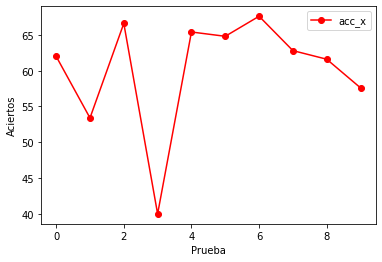

In [44]:
get_graphic_plot()

#WILCOXON

In [42]:
def wilcoxon(x,y):
  wilcox_V, p_value =  wilcoxon(x, y, alternative='greater', zero_method='wilcox', correction=False)
  print('Resultado completo del test de Wilcoxon')
  print(f'Wilcox V: {wilcox_V}, p-value: {p_value:.2f}')
  return wilcox_V, p_value

#PRUEBA DE DOS MODELOS SOLAMENTE CON AUC PARA LA PARTE BÁSICA

In [54]:
acc_per_fold_model1, loss_per_fold_model1, auc_per_fold_model1, acc_percent_per_fold_model1, auc_percent_per_fold_model1,  model = cross_validation(10 , ["relu", "relu" , "relu" , "relu", "softmax"] , 'adam' , True ,32 , 8 )

acc_per_fold_model2, loss_per_fold_model2, auc_per_fold_model2, acc_percent_per_fold_model2, auc_percent_per_fold_model2,  model = cross_validation(10 , ["relu", "relu" , "relu" , "relu", "softmax"] , 'adam' , False ,32 , 8 )



Before  4500
Getting the len of the arrays  563   563
The old size was  563
The shape is  (4500, 32, 32, 3)
The shape is  (5063, 32, 32, 3)
The shape is  (5626, 32, 32, 3)
The shape is  (6189, 32, 32, 3)
The shape is  (6752, 32, 32, 3)
The shape is  (7315, 32, 32, 3)
The new size is  3941
Y TRAIN [0 0 0 ... 1 1 1]
After  3941
X_train (7878, 32, 32, 3) X_test (500, 32, 32, 3)
y_train (7878,) y_test (500,)
y_train_nn (7878, 2) y_test_nn (500, 2)
The batch and the epoch are   32 ,  8
Epoch 1/8
247/246 [==============================] - 10s 41ms/step - loss: 0.2348 - accuracy: 0.9085
Epoch 2/8
247/246 [==============================] - 10s 41ms/step - loss: 0.1649 - accuracy: 0.9279
Epoch 3/8
247/246 [==============================] - 10s 41ms/step - loss: 0.1402 - accuracy: 0.9331
Epoch 4/8
247/246 [==============================] - 10s 41ms/step - loss: 0.1361 - accuracy: 0.9354
Epoch 5/8
247/246 [==============================] - 10s 41ms/step - loss: 0.1265 - accuracy: 0.9434
Epoch 6/8

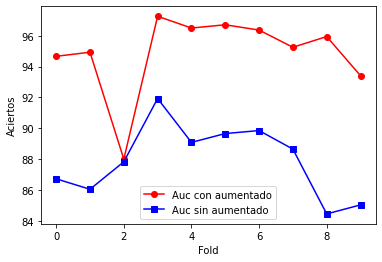

In [61]:
plt.plot(range(len( auc_percent_per_fold_model1)) , auc_percent_per_fold_model1 , 'ro-',label='Auc con aumentado')
plt.plot(range(len( auc_percent_per_fold_model2)) , auc_percent_per_fold_model2 , 'bs-',label='Auc sin aumentado')
plt.ylabel('Aciertos')
plt.xlabel('Fold')
plt.legend()

In [60]:
v, p_value = wilcoxon(auc_percent_per_fold_model1 , auc_percent_per_fold_model2)
print("P VALUE " , p_value)

P VALUE  0.005062032126267864


#SHAP

In [47]:

def shap(model ):
  import shap
  background = X[np.random.choice(X.shape[0],100 , replace = False)]
  e = shap.DeepExplainer(model, background)
  shap_values= e.shap_values(X[1:6])
  shap.image_plot(shap_values, X[1:6])
  return



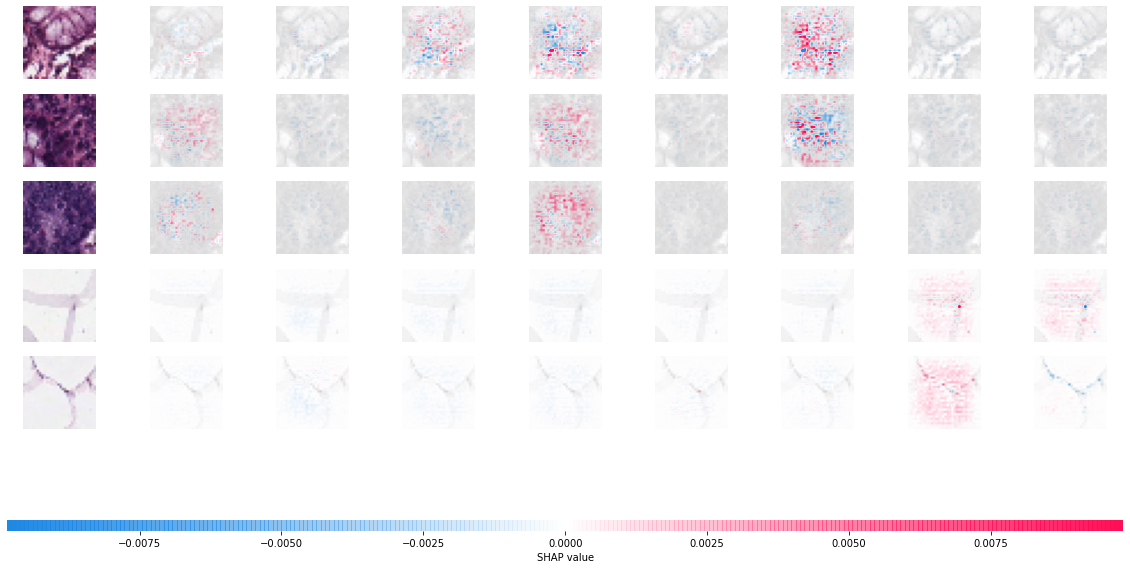

In [49]:
shap(model )

In [ ]:
shap.dependence_plot("RM", shap_values, X)

AttributeError: ignored

In [ ]:
shap.summary_plot(shap_values, X)

AttributeError: ignored

## Prediction

### Testing AUC result for two and multiple classes

In [ ]:
for i in range(len(full_test_X)):

  y_scores = model.predict(full_test_X[i]) # Confidence prediction per class
  y_pred = y_scores.argmax(axis=1) # Select classes with most confidence prediction

  if nb_classes ==  2:
    print(f'AUC {metrics.roc_auc_score(full_test_Y[i], np.round(y_scores[:,1],2)):.4f} ')
  else:
    print(f'AUC {metrics.roc_auc_score(full_test_Y[i], y_scores, multi_class = "ovr"):.4f} ')

AUC 0.9311 
AUC 0.9311 
AUC 0.9311 
AUC 0.9311 
AUC 0.9408 
AUC 0.9343 
AUC 0.9315 
AUC 0.9367 
AUC 0.9350 
AUC 0.9358 
AUC 0.9380 
AUC 0.9350 
AUC 0.9379 


## More metrics about results

We can find more information about `precision`, `recall` and `f1` metrics in <https://en.wikipedia.org/wiki/Precision_and_recall>.

In [ ]:
for i in range(len(full_test_X)):
  y_scores = model.predict(full_test_X[i]) # Confidence prediction per class
  y_pred = y_scores.argmax(axis=1) # Select classes with most confidence prediction

  if nb_classes ==  2:
    print(f'AUC {metrics.roc_auc_score(full_test_Y[i], np.round(y_scores[:,1],2)):.4f} ')
  else:
    print(f'AUC {metrics.roc_auc_score(full_test_Y[i], y_scores, multi_class = "ovr"):.4f} ')
  print('Predictions', collections.Counter(y_pred),'\n')

  print('Confusion matrix')
  print(metrics.confusion_matrix(full_test_Y[i],y_pred),'\n')

  target_names = ['TUMOR', 'HEALTHY'] if nb_classes ==  2 else ['TUMOR','STROMA','COMPLEX','LYMPHO','DEBRIS','MUCOSA','ADIPOSE','EMPTY']

  print(metrics.classification_report(full_test_Y[i], y_pred, target_names=target_names))

AUC 0.9311 
Predictions Counter({5: 95, 3: 88, 7: 70, 0: 60, 4: 52, 6: 51, 2: 51, 1: 33}) 

Confusion matrix
[[27  0  0 28  0  8  0  0]
 [ 0 15 19  0 15 14  0  0]
 [18  1 25  1  3 14  0  0]
 [ 8  0  2 50  0  2  0  0]
 [ 0 17  4  0 26 13  3  0]
 [ 7  0  1  9  1 44  0  0]
 [ 0  0  0  0  7  0 46  9]
 [ 0  0  0  0  0  0  2 61]] 

              precision    recall  f1-score   support

       TUMOR       0.45      0.43      0.44        63
      STROMA       0.45      0.24      0.31        63
     COMPLEX       0.49      0.40      0.44        62
      LYMPHO       0.57      0.81      0.67        62
      DEBRIS       0.50      0.41      0.45        63
      MUCOSA       0.46      0.71      0.56        62
     ADIPOSE       0.90      0.74      0.81        62
       EMPTY       0.87      0.97      0.92        63

    accuracy                           0.59       500
   macro avg       0.59      0.59      0.58       500
weighted avg       0.59      0.59      0.58       500

AUC 0.9311 
Predictio